# Sequential Estimators of Binary Sequences

This notebook presents and implements a few methods of sequentially predicting binary sequences.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Problem Formulation

Suppose we are continuously receiving a sequence of bits, $X^N = (X_1,X_2, \dots,X_N) \in \{0,1\}^N$, where each bit is distributed iid Bernoulli, i.e. $X_n \sim B(\theta)$ for $n=1,\dots,N$ with $\theta \in [0,1]$. Our goal is to, at each time $n$, estimate a probability assignment for the next bit:

$$
\hat{P}(x_{n+1} \mid x^n)
$$

Because there are only two possible values that $x_{n+1}$, we can equivalently estimate $P_0^n = Pr\{x_{n+1} = 0 \}$ and $P_1^n = Pr\{x_{n+1} = 1 \}$ with $\hat{P}_0^n$ and $\hat{P}_1^n$. Noting that we must have the relationship $\hat{P}_0^n = 1 - \hat{P}_1^n$, we can define $\hat{\theta}_n = \hat{P}_1^n$ and our estimate for each $n$ becomes:

$$
\hat{P}(x_{n+1} \mid x^n) = \hat{\theta}_n^{x_{n+1}}(1-\hat{\theta}_n)^{1-x_{n+1}}
$$

We'll start by generating a sequence that we will try to estimate sequentially.

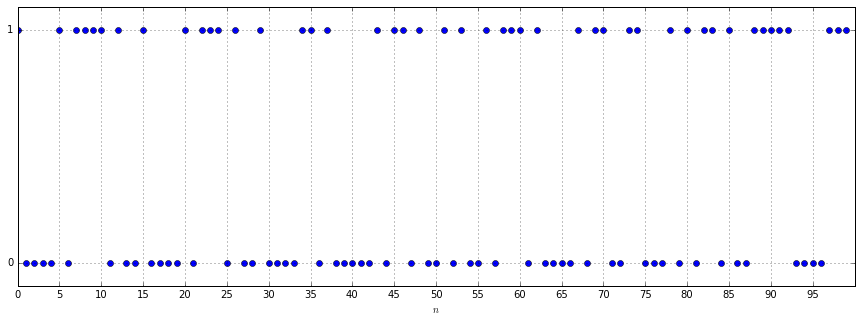

In [19]:
def gen_sequence(N=100,theta=0.5,plot = True):
    seq = np.random.binomial(1,theta,N)
    if not plot:
        return seq
    else:
        fig,ax = plt.subplots(figsize = (15,5))
        ax.plot(seq,'o')
        ax.xaxis.set(ticks=np.arange(0,N,N//20))
        ax.yaxis.set(ticks=(0,1), ticklabels=('0', '1'))
        ax.set_ylim([-0.1,1.1])
        ax.grid('on')
        ax.set_xlabel('$n$')
        return seq, ax
        
gen_sequence();

## Estimators

There are a number of ways to predict the probability of heads on the next outcome given all the past outcomes based on different philosophies.

### Maximum Likelihood Estimator
For starters, we'll consider the maximum likelihood estimate. this means that at each time $n$, we want to find the parameter $\hat{\theta}_n \in [0,1]$ that maximizes the likelihood of seeing the sequence so far, $x^n$. In other words, which value $\hat{\theta}_n$ would be the most likely explanation of the observed sequence without considering any prior notions we may have of the true value of $\theta$. Formally, letting $M_n$ be the number of ones in the sequence thus far (and thus $n - M_n$ the number of zeroes):

\begin{align*}
\hat{\theta}_n^{ML} 
&= \underset{\theta\in[0,1]}{\operatorname{argmax}} P(x^{n-1} ; \theta) \\
&= \underset{\theta\in[0,1]}{\operatorname{argmax}} \theta^{M_{n-1}} (1-\theta)^{(n-M_{n-1})} \\
&= \underset{\theta\in[0,1]}{\operatorname{argmax}} M_{n-1}\log\theta  + (n-1-M_{n-1}) \log(1-\theta) 
\end{align*}

Taking the derivative and setting to zero:

\begin{align*}
&\frac{d}{d\theta} P(x_{n-1} ; \theta) = 0 \\
& (1-\hat{\theta}_n^{ML})M_{n-1} = \hat{\theta}_n^{ML}(n-1-M_{n-1}) \\
& \hat{\theta}_n^{ML} = \frac{M_{n-1}}{n-1}
\end{align*}

Put simply, at each time we will predict the probability of the next bit being 1 as the proportion of 1s in all of the previous bits. This estimator has the nice quality of being [unbiased](https://en.wikipedia.org/wiki/Bias_of_an_estimator), meaning that the expected value of the estimated parameter is the true parameter. Note that because the estimated parameter is a function of the random sequence, it is itself a random variable.

In [20]:
class MLEstimator:
    
    def __init__(self,seq):
        self.label = "ML"
        self.seq = seq
        self.theta = 1/2
        self.M = 0
        self.n = 1
        
    def predict(self):
        est_theta = [self.theta]
        for xn in self.seq:
            self.n += 1
            self.M += xn
            self.theta = self.M / (self.n-1)
            est_theta.append(self.theta)
        return est_theta

While the ML estimator is intuitive, simple to derive, and unbiased, it has its flaws:

1) $\hat{\theta}_1^{ML}$ is undefined. Under the ML philosophy, there is no sound way to estimate the first bit. What parameter provides the most likely explanation for the observance of *nothing*? Above we simply set $\hat{\theta}_1^{ML}=0.5$, although this is not in accordance with any reasoning we can develop with a ML mindset.

2) The ML estimator is overconfident. If $X^n=(1,1,\dots,1)$, then the estimator will assume that there is *no chance* that $X_{n+1}=0$, i.e. $\hat{\theta}_{n+1}^{ML}=1$. While this may seem reasonable for some very large $n$, it is not all that unlikely that for, say, $\theta = 0.75$, our sequence begins with $X^3 = (1,1,1)$ (in fact, this would happen almost half of the time). Furthermore, it is guaranteed that we can't observe both outcomes for the first bit, which implies that $\hat{\theta}_2^{ML} \in \{0,1\}$. In other words, after only 1 flip, the ML estimator it is guaranteed that the ML esimator is certain about what the next flip will be.

3) The ML estimator has high variance. As mentioned earlier, because the estimated parameter is random, it has an associated variance. We want this variance to be low so that small changes in the observation don't result in large changes in the estimated parameter. It is common for unbiased estimators to have high variance, and this is known as the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). To illustrate the high variance of the ML estimator, consider again the first observed bit in the case when $\theta=0.5$. While it is equally likely that $X_1 = 0$ and $X_1=1$, the resulting $\hat{\theta}_2^{ML}$ from these observations will be maximally different. In this sense, the value of the estimated parameter could not vary any more than it does between those two equally likely outcomes.

### KT-Estimator

In [5]:
class KTEstimator:
    
    def __init__(self,seq):
        self.label = "KT"
        self.seq = seq
        self.theta = 1/2
        self.count1 = 0
        self.count0 = 0
        
    def predict(self):
        est_theta = [self.theta]
        for xn in self.seq:
            self.count1 += xn
            self.count0 += (1-xn)
            self.theta = ((0.5 + self.count1) / (self.count1 + self.count0 + 1))
            est_theta.append(self.theta)
        return est_theta

### Bayesian Mixture of Expert Advice - Stationary Experts

In [6]:
class BMEAEstimator:
    
    def __init__(self,seq,K=50):
        self.label = "BMEA"
        self.seq = seq
        self.K = K
        self.w = np.ones(self.K)*(1/self.K)
        self.E = np.linspace(0,1,self.K)
        
    def p(self,xn,thetai):
        return (thetai**xn)*((1-thetai)**(1-xn))
    
    def predict(self):
        est_theta = []
        for xn in self.seq:
            est_theta.append(np.dot(self.E,self.w))
            self.pn = np.asarray([self.p(xn,self.E[[i]]) for i in range(self.K)]).reshape((self.K))
            self.w = np.multiply(self.pn,self.w)/np.dot(self.pn.T,self.w)
        return est_theta
            

### Bayesian Mixture of Expert Advice - Time Varying Experts

In [7]:
class BMEA_TVEstimator:
    
    def __init__(self,seq,K=10):
        self.label = "BMEA-TV"
        self.seq = seq
        self.K = K**2
        self.w = np.ones(self.K)*(1/self.K)
        self.E1 = np.repeat(np.linspace(0,1,K),K)
        self.E2 = np.tile(np.linspace(0,1,K),K)
        
    def p(self,xn,thetai):
        return (thetai**xn)*((1-thetai)**(1-xn))
    
    def predict(self):
        est_theta = []
        for n,xn in enumerate(self.seq):
            if n < len(self.seq)//2:
                E = self.E1
            else:
                E = self.E2
            est_theta.append(np.dot(E,self.w))
            self.pn = np.asarray([self.p(xn,E[[i]]) for i in range(self.K)]).reshape((self.K))
            self.w = np.multiply(self.pn,self.w)/np.dot(self.pn.T,self.w)
        return est_theta
            

### Bayesian Mixture of Expert Advice - Shrinking Towards Prior

In [8]:
class BMEA_STPEstimator:
    
    def __init__(self,seq,K=10,lam=0.999,alpha=0):
        self.label = "BMEA-STP"
        self.seq = seq
        self.K = K
        self.w = np.ones(self.K)*(1/self.K)
        self.w0 = self.w
        self.E = np.linspace(0,1,self.K)
        self.lam = lam
        self.alpha = alpha
        
    def p(self,xn,thetai):
        return (thetai**xn)*((1-thetai)**(1-xn))
    
    def predict(self):
        est_theta = []
        for n,xn in enumerate(self.seq):
            lam = self.lam*(n+1)**(-self.alpha)
            est_theta.append(np.dot(self.E,self.w))
            self.pn = np.asarray([self.p(xn,self.E[i]) for i in range(self.K)]).reshape((self.K))
            self.w_prime = np.multiply(self.pn,self.w)/np.dot(self.pn.T,self.w)
            self.w = lam*self.w_prime + (1-lam)*self.w0
        return est_theta
            

## Simulations

In [9]:
estimators = [MLEstimator,KTEstimator,BMEAEstimator,BMEA_TVEstimator,BMEA_STPEstimator]

### Stationary Distribution

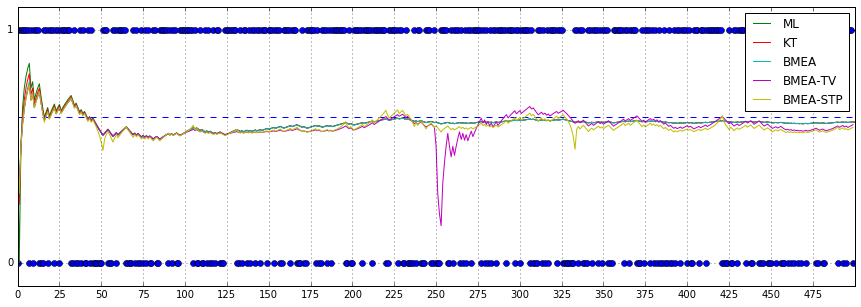

In [17]:
true_p = np.random.uniform()
N = 500
seq, ax = gen_sequence(N=N,theta=true_p)
ax.plot([0,N],[true_p,true_p],'b--')
for estimator_type in estimators:
    estimator = estimator_type(seq)
    est_p = estimator.predict()
    ax.plot(est_p,label=estimator.label)
plt.legend();

### Time-Varying Distribution

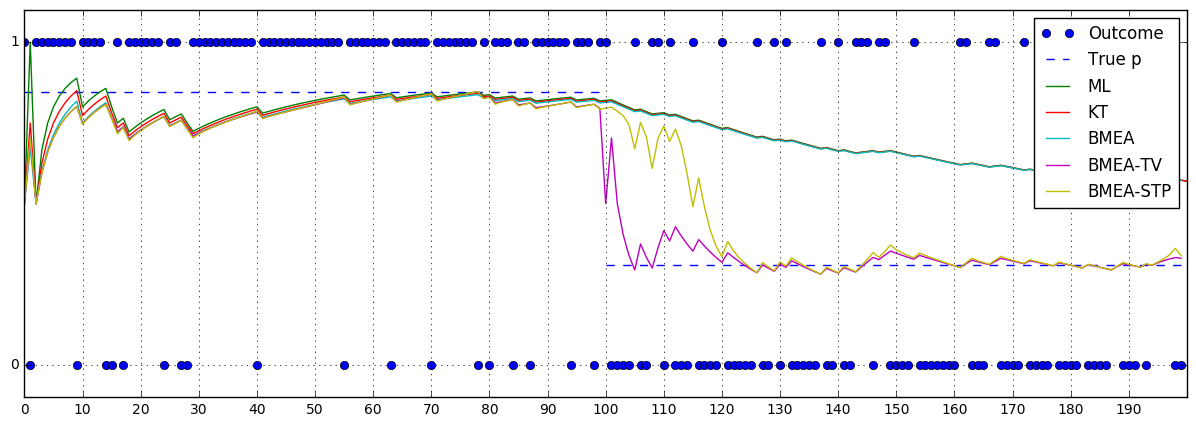

In [753]:
N = 200
true_p1 = np.random.uniform()
seq1 = gen_sequence(N=N//2,theta=true_p1,plot=False)
true_p2 = np.random.uniform()
seq2 = gen_sequence(N=N//2,theta=true_p2,plot=False)
seq = np.hstack((seq1,seq2))

fig,ax = plt.subplots(figsize = (15,5))
ax.plot(seq,'o',label='Outcome')
ax.plot([0,N//2],[true_p1,true_p1],'b--',label='True p')
ax.plot([N//2,N],[true_p2,true_p2],'b--')

for estimator_type in estimators:
    estimator = estimator_type(seq)
    est_p = estimator.predict()
    ax.plot(est_p,label=estimator.label)
    
ax.xaxis.set(ticks=np.arange(0,N,N//20))
ax.yaxis.set(ticks=(0,1), ticklabels=('0', '1'))
ax.set_ylim([-0.1,1.1])
ax.legend()
ax.grid('on')